<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
import sys
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from pathlib import Path
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"olesya1005","key":"161d7daac48af9c020bfdb14cea57ba5"}'}

In [8]:
! cp kaggle.json ~/.kaggle/

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
! kaggle datasets list

ref                                                        title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/top-spotify-songs-2023                    Most Streamed Spotify Songs 2023                    47KB  2023-08-26 11:04:57           9434        307  1.0              
josephinelsy/spotify-top-hit-playlist-2010-2022            Spotify Top Hit Playlist (2010-2022)               210KB  2023-09-08 06:11:44           1724         51  1.0              
harshalhonde/starbucks-reviews-dataset                     Starbucks Reviews Dataset                          170KB  2023-09-15 08:21:59            456         26  1.0              
joebeachcapital/students-performance                       Students Performance           

In [11]:
! kaggle datasets download -d tommykamaz/faces-dataset-small

100% 3.99G/3.99G [00:44<00:00, 136MB/s]
100% 3.99G/3.99G [00:44<00:00, 95.6MB/s]


In [12]:
! unzip faces-dataset-small.zip -d data

Archive:  faces-dataset-small.zip
  inflating: data/faces_dataset_small/00055.png  
  inflating: data/faces_dataset_small/00237.png  
  inflating: data/faces_dataset_small/00240.png  
  inflating: data/faces_dataset_small/00241.png  
  inflating: data/faces_dataset_small/00242.png  
  inflating: data/faces_dataset_small/00243.png  
  inflating: data/faces_dataset_small/00244.png  
  inflating: data/faces_dataset_small/00245.png  
  inflating: data/faces_dataset_small/00246.png  
  inflating: data/faces_dataset_small/00247.png  
  inflating: data/faces_dataset_small/00248.png  
  inflating: data/faces_dataset_small/00249.png  
  inflating: data/faces_dataset_small/00253.png  
  inflating: data/faces_dataset_small/00255.png  
  inflating: data/faces_dataset_small/00257.png  
  inflating: data/faces_dataset_small/00258.png  
  inflating: data/faces_dataset_small/00259.png  
  inflating: data/faces_dataset_small/00260.png  
  inflating: data/faces_dataset_small/00261.png  
  inflating: dat

In [13]:
def get_dataloader(image_size, batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object
  """
  data_dir = Path('/content/data')
  train_data= ImageFolder(data_dir, transform=tt.Compose([
      tt.Resize(image_size),
      tt.CenterCrop(image_size),
      tt.ToTensor(),
      tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ]))
  train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  return train_loader

In [14]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(b, device) for b in data]
    return data.to(device, non_blocking=True)


class DataToDevice():
    def __init__(self, loader, device):
        self.loader = loader
        self.device = device
    def __iter__(self):
        for b in self.loader:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.loader)

In [15]:
image_size = 128
batch_size = 16

train_loader = get_dataloader(image_size, batch_size)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

train_loader = DataToDevice(train_loader, device)

cuda


In [16]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [17]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

## Часть 2. Построение и обучение модели (2 балла)

In [18]:
class DiscBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size : int = 4, stride : int = 2, padding : int = 1, bias : bool = False):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x) -> torch.Tensor:
        return self.block(x)

In [19]:
class GenBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size : int = 4, stride: int = 2, padding : int = 1, bias : bool = False):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.block(x)

In [20]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = DiscBlock(3, 64)  #128->64
        self.block2 = DiscBlock(64, 128)  #64->32
        self.block3 = DiscBlock(128, 256)   #32->16
        self.block4 = DiscBlock(256, 512)   #16->8
        self.block5 = DiscBlock(512, 1024)  #8->4
        self.block6 = nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False)  #4->1
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.sigmoid(self.flatten(self.block6(x)))
        return x

In [21]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = GenBlock(100, 1024, stride=1, padding=0)  #1->4
        self.block2 = GenBlock(1024, 512)   #4->8
        self.block3 = GenBlock(512, 256)  #8->16
        self.block4 = GenBlock(256, 128)  #16->32
        self.block5 = GenBlock(128, 64)   #32->64
        self.block6 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False)   #64->128
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.tanh(self.block6(x))
        return x

In [22]:
generator = Generator()
discriminator = Discriminator()

torch.Size([16, 3, 128, 128])


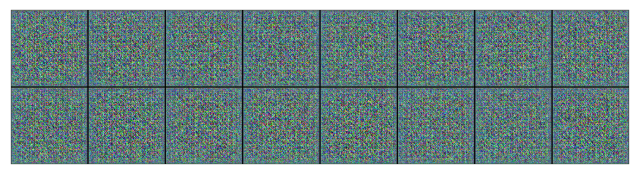

In [23]:
latent_size=100
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [24]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [25]:
n_images = 64
fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)

In [26]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [27]:
def init_wb(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_uniform_(m.weight.data, gain = nn.init.calculate_gain('leaky_relu', 0.2))
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.uniform_(m.weight.data, 0.0, 1.0)
        nn.init.constant_(m.bias.data, 0.0)

In [28]:
lr = 0.0002

model = {
    "discriminator": discriminator,
    "generator": generator
}

model['generator'].apply(init_wb)
model['discriminator'].apply(init_wb)

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [29]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model['discriminator'].to(device)
    model['generator'].to(device)
    model['discriminator'].train()
    model['generator'].train()
    torch.cuda.empty_cache()
    res_disc_loss = []
    res_gen_loss = []
    res_disc_score = []
    res_gen_score = []
    batch_size = 64

    optimizer = {'discriminator' : torch.optim.Adam(model['discriminator'].parameters(), lr=lr, betas=(0.5, 0.999)),
                 'generator' : torch.optim.Adam(model['generator'].parameters(), lr=lr, betas=(0.5, 0.999))}

    for epoch in range(epochs):
        loss_disc_per_ep = []
        loss_gen_per_ep = []
        disc_score_per_ep = []
        gen_score_per_ep = []

        for data, _ in (train_loader):
            optimizer['discriminator'].zero_grad()

            disc_pred = model['discriminator'](data)
            disc_target = torch.ones(data.size(0), 1, device=device)
            disc_loss = criterion['discriminator'](disc_pred, disc_target)

            d_score = torch.mean(disc_pred).item()

            latent_v = torch.randn(batch_size, latent_size, 1, 1, device=device)
            gen_image = model['generator'](latent_v)

            gen_pred = model['discriminator'](gen_image)
            gen_target = torch.zeros(gen_image.size(0), 1, device=device)
            gen_loss = criterion['discriminator'](gen_pred, gen_target)

            g_score = torch.mean(gen_pred).item()

            disc_score_per_ep.append(d_score)
            gen_score_per_ep.append(g_score)

            loss = disc_loss + gen_loss
            loss.backward()
            optimizer['discriminator'].step()

            loss_disc_per_ep.append(loss.item())


            #generator
            optimizer['generator'].zero_grad()
            latent_v = torch.randn(batch_size, latent_size, 1, 1, device=device)
            gen_image = model['generator'](latent_v)
            gen_pred = model['discriminator'](gen_image)
            gen_real = torch.ones(gen_image.size(0), 1, device=device)

            gen_loss = criterion['generator'](gen_pred, gen_real)
            gen_loss.backward()
            optimizer['generator'].step()

            loss_gen_per_ep.append(gen_loss.item())

        res_disc_loss.append(np.mean(loss_disc_per_ep))
        res_gen_loss.append(np.mean(loss_gen_per_ep))
        res_disc_score.append(np.mean(disc_score_per_ep))
        res_gen_score.append(np.mean(gen_score_per_ep))

        print("Epoch [{}/{}], res_gen_loss: {:.4f}, res_disc_loss: {:.4f}, res_disc_score: {:.4f}, res_gen_score: {:.4f}".format(
            epoch+1, epochs,
            res_gen_loss[-1], res_disc_loss[-1], res_disc_score[-1], res_gen_score[-1]))

        if epoch == epochs - 1:
            save_samples(epoch+start_idx, fixed_latent, show=False)

    return res_disc_loss, res_gen_loss, res_disc_score, res_gen_score

In [30]:
epochs = 120

In [31]:
disc_loss, gen_loss, disc_score, gen_score = fit(model, criterion, epochs, lr)

Epoch [1/120], res_gen_loss: 12.9166, res_disc_loss: 0.4027, res_disc_score: 0.9121, res_gen_score: 0.0986
Epoch [2/120], res_gen_loss: 5.4054, res_disc_loss: 0.7842, res_disc_score: 0.7890, res_gen_score: 0.2063
Epoch [3/120], res_gen_loss: 4.4561, res_disc_loss: 0.7895, res_disc_score: 0.7626, res_gen_score: 0.2337
Epoch [4/120], res_gen_loss: 4.1177, res_disc_loss: 0.8957, res_disc_score: 0.7292, res_gen_score: 0.2654
Epoch [5/120], res_gen_loss: 3.6750, res_disc_loss: 0.8851, res_disc_score: 0.7218, res_gen_score: 0.2729
Epoch [6/120], res_gen_loss: 3.5025, res_disc_loss: 0.8258, res_disc_score: 0.7316, res_gen_score: 0.2622
Epoch [7/120], res_gen_loss: 3.4691, res_disc_loss: 0.7622, res_disc_score: 0.7463, res_gen_score: 0.2506
Epoch [8/120], res_gen_loss: 3.7300, res_disc_loss: 0.7472, res_disc_score: 0.7578, res_gen_score: 0.2428
Epoch [9/120], res_gen_loss: 3.6896, res_disc_loss: 0.7501, res_disc_score: 0.7560, res_gen_score: 0.2417
Epoch [10/120], res_gen_loss: 3.6342, res_dis

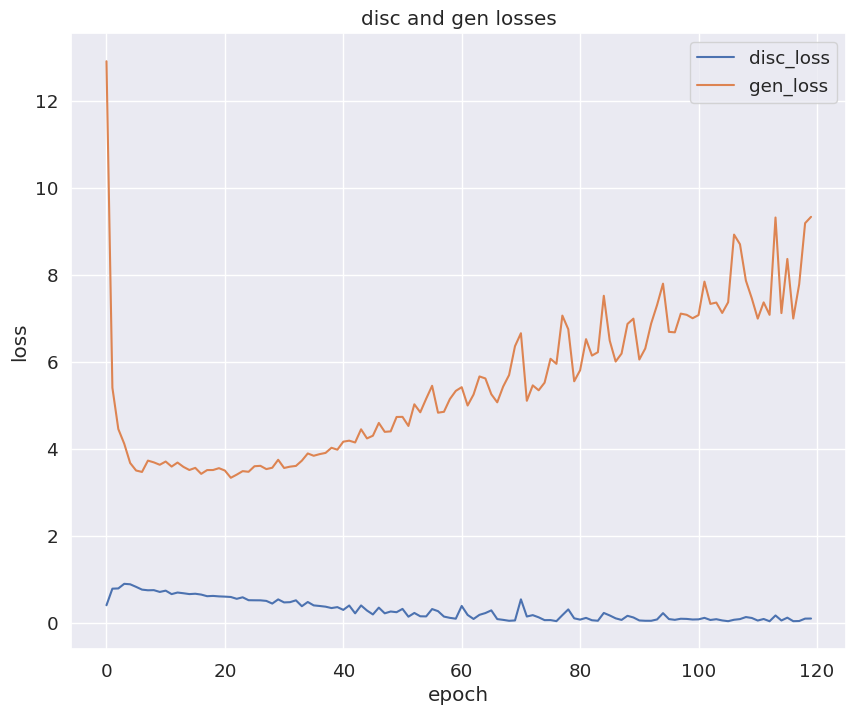

In [32]:
plt.figure(figsize=(10, 8))
plt.plot(range(epochs), disc_loss, label='disc_loss')
plt.plot(range(epochs), gen_loss, label='gen_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('disc and gen losses')
plt.legend()
plt.show()

## Часть 3. Генерация изображений (1 балл)

In [33]:
generated_img = cv2.imread(f'./generated/generated-images-0{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

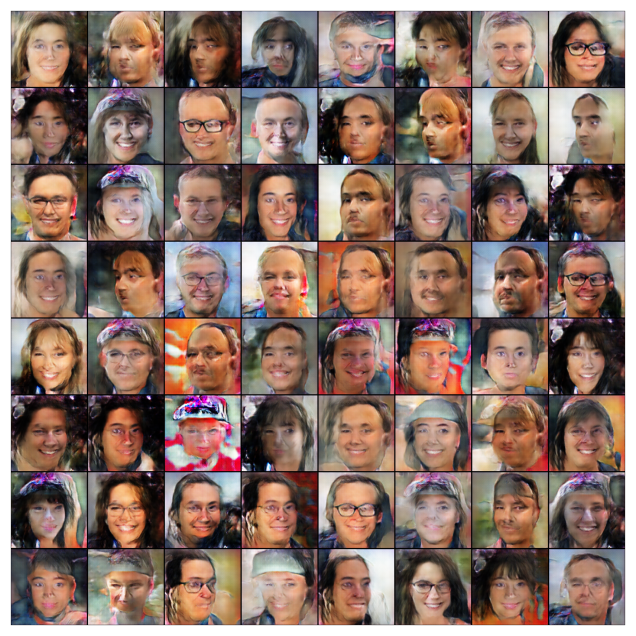

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

In [35]:
generated_img.shape

(1042, 1042, 3)

torch.Size([16, 3, 128, 128])


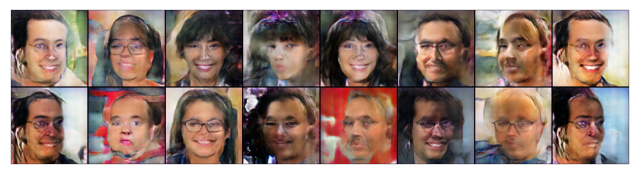

In [36]:
latent_size=100
xb = torch.randn(batch_size, latent_size, 1, 1, device=device)
fake_images = model['generator'](xb).cpu().detach()
print(fake_images.shape)
show_images(fake_images)

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

In [37]:
numb_img = 1000
fixed_latent = torch.randn(numb_img, latent_size, 1, 1, device=device)
fake_img = model['generator'](fixed_latent).cpu().detach()
real_img = next(iter(get_dataloader(128, numb_img)))[0].cpu().detach()

In [38]:
images = torch.cat((fake_img, real_img), 0).numpy().reshape(-1, 3 * 128 * 128)
labels = torch.cat((torch.zeros(numb_img, 1), torch.ones(numb_img, 1))).numpy()

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
knn_model = KNeighborsClassifier(n_neighbors=1)
loo = LeaveOneOut()

In [41]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
label, preds = [],[]
for i, (train_index, test_index) in enumerate(loo.split(images)):
    images_train, images_test = images[train_index], images[test_index]
    labels_train, labels_test = labels[train_index], labels[test_index]

    knn_model.fit(images_train, labels_train.reshape(-1))
    predictions = knn_model.predict(images_test)

    label.append(labels_test.reshape(-1)[0])
    preds.append(predictions[0])

print(classification_report(label, preds))

              precision    recall  f1-score   support

         0.0       0.62      1.00      0.77      1000
         1.0       0.99      0.39      0.56      1000

    accuracy                           0.69      2000
   macro avg       0.81      0.70      0.66      2000
weighted avg       0.81      0.69      0.66      2000



<Axes: >

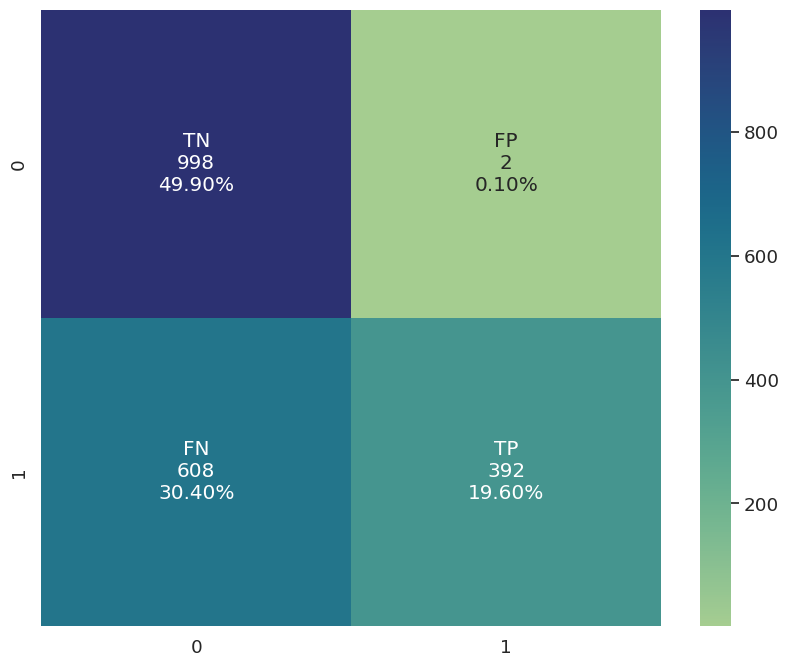

In [42]:
plt.figure(figsize=(10, 8))

cf_matrix = confusion_matrix(np.array(label), np.array(preds))
names = ['TN','FP','FN','TP']
counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
l = [f'{x1}\n{x2}\n{x3}' for x1, x2, x3 in zip(names, counts, percentages)]
l = np.asarray(l).reshape(2,2)
sns.heatmap(cf_matrix, annot=l, fmt='', cmap='crest')

### 4.2. Визуализация распределений (2 балла)

In [43]:
from sklearn.manifold import TSNE
emb = images
labels = labels.reshape(-1, 1)
emb = TSNE(n_components=2).fit_transform(emb)

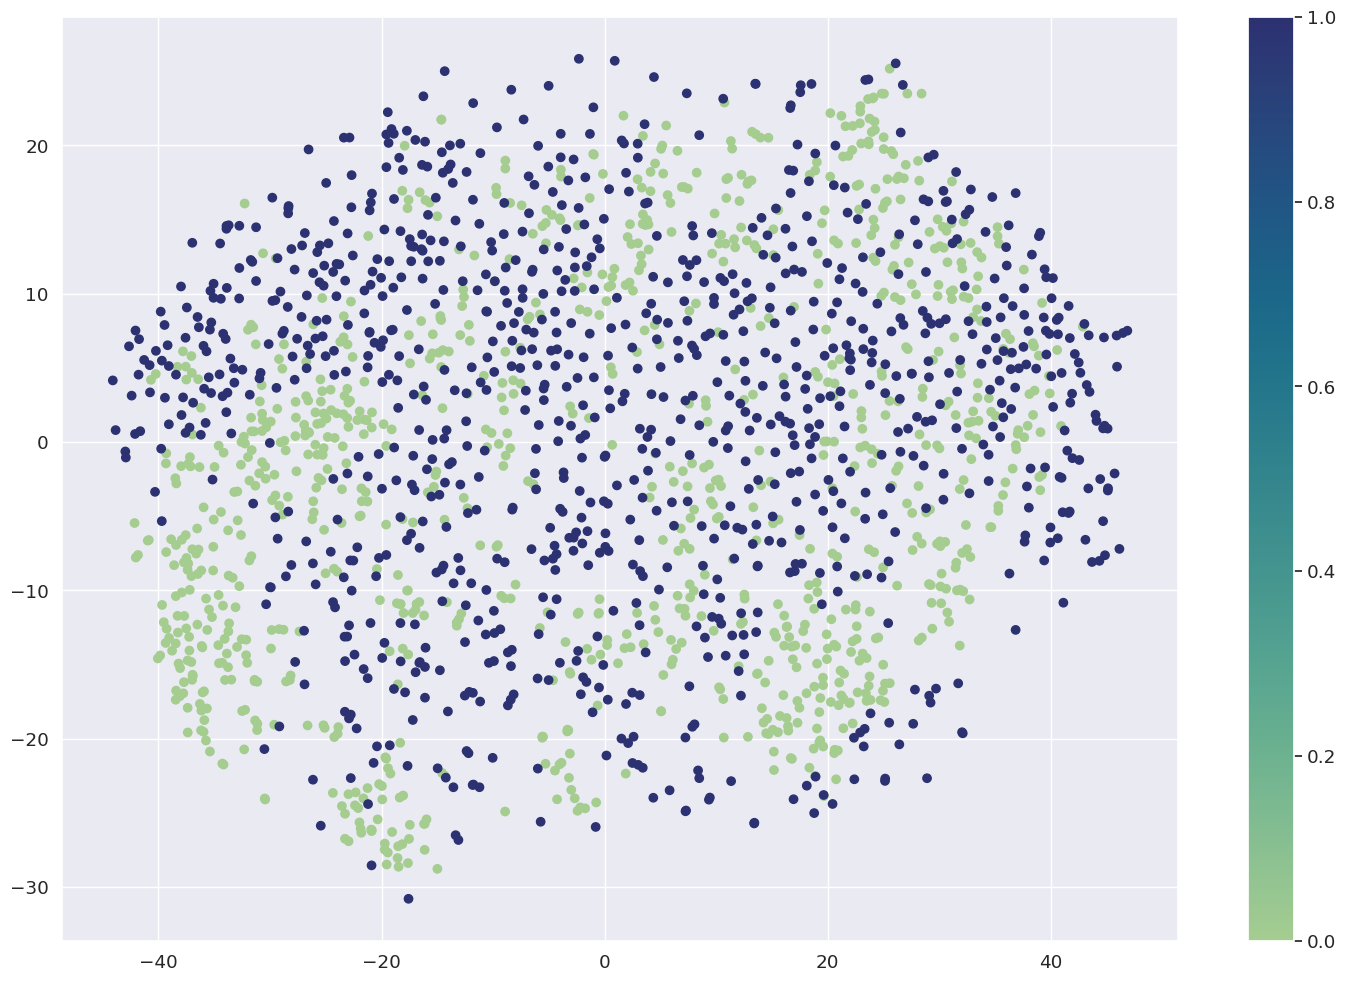

In [44]:
plt.figure(figsize=(18, 12))
plt.scatter(emb[:, 0], emb[:, 1], c=labels, cmap='crest')
plt.colorbar()

Accuracy 69% - неплохой результат, однако наилучшим был бы 50%, если бы модель угадывала класс изображений, то есть практически не различала сгенерированные и реальные изображения между собой. По TSNE видно, что распределения достаточно близки, однако в некоторой степени имеют различия. Можно сказать, что модель хорошо справляется с задачей генерации изображений лиц.